# LSTM
Long Short Term Memory

## Loading the pre-requisites

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM as a single-step model

* We will use a wide window function to provide the LSTM with a sequence of data to be processed.

In [10]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [12]:
from tensorflow.keras.layers import LSTM, Dense

In [13]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

In [14]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
384/384 [==============================] - 12s 20ms/step - loss: 0.0411 - mean_absolute_error: 0.1406 - val_loss: 0.0152 - val_mean_absolute_error: 0.0890
Epoch 2/50
384/384 [==============================] - 8s 22ms/step - loss: 0.0096 - mean_absolute_error: 0.0701 - val_loss: 0.0061 - val_mean_absolute_error: 0.0556
Epoch 3/50
384/384 [==============================] - 9s 24ms/step - loss: 0.0053 - mean_absolute_error: 0.0514 - val_loss: 0.0042 - val_mean_absolute_error: 0.0456
Epoch 4/50
384/384 [==============================] - 8s 20ms/step - loss: 0.0043 - mean_absolute_error: 0.0461 - val_loss: 0.0038 - val_mean_absolute_error: 0.0434
Epoch 5/50
384/384 [==============================] - 8s 22ms/step - loss: 0.0040 - mean_absolute_error: 0.0440 - val_loss: 0.0035 - val_mean_absolute_error: 0.0412
Epoch 6/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0038 - mean_absolute_error: 0.0425 - val_loss: 0.0032 - val_mean_absolute_error: 0.0392
Epoch 7/5

In [15]:
val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 1s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0265


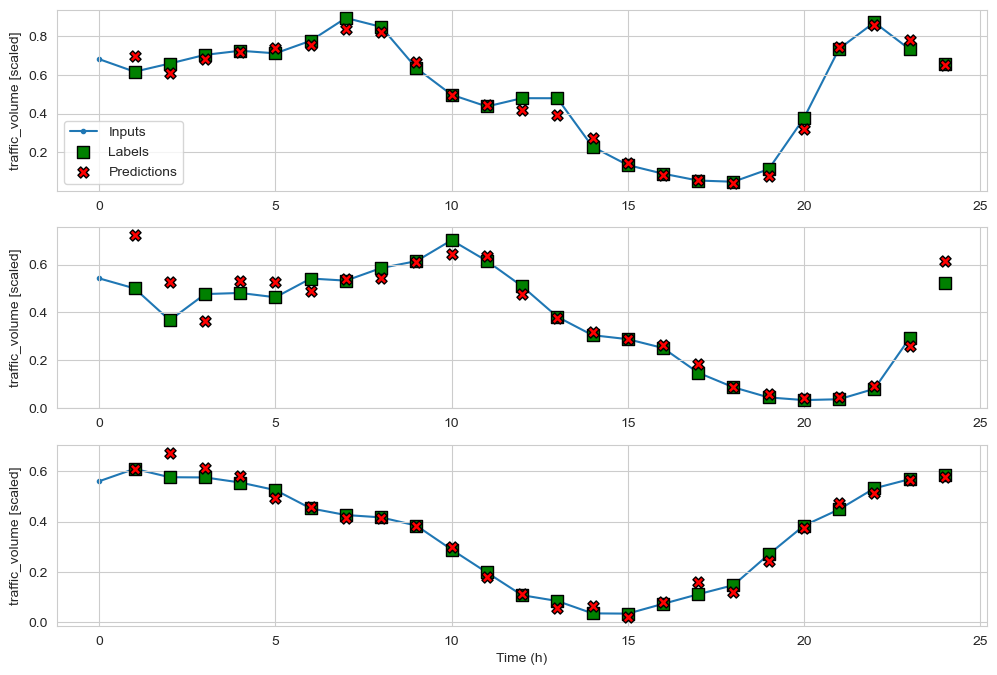

In [16]:
wide_window.plot(lstm_model)

* We now compare this with the baseline models from the previous notebook.
* We get the values from the previous models as,

In [17]:
mae_val = [0.083, 0.066, 0.032]
mae_test = [0.081, 0.063, 0.032]

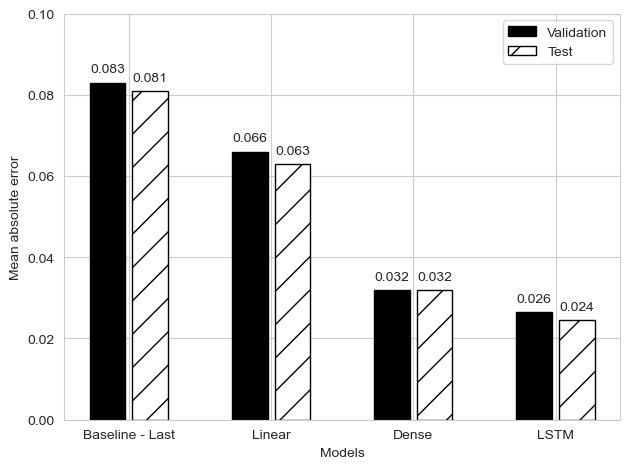

In [18]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* As we can see the LSTM model is better than all the models so far.

## LSTM as a multi-step model

In [19]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [20]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [21]:
history = compile_and_fit(ms_lstm_model, multi_window)

Epoch 1/50
383/383 [==============================] - 13s 23ms/step - loss: 0.0454 - mean_absolute_error: 0.1536 - val_loss: 0.0196 - val_mean_absolute_error: 0.0972
Epoch 2/50
383/383 [==============================] - 8s 22ms/step - loss: 0.0159 - mean_absolute_error: 0.0865 - val_loss: 0.0172 - val_mean_absolute_error: 0.0906
Epoch 3/50
383/383 [==============================] - 8s 22ms/step - loss: 0.0145 - mean_absolute_error: 0.0809 - val_loss: 0.0160 - val_mean_absolute_error: 0.0841
Epoch 4/50
383/383 [==============================] - 8s 22ms/step - loss: 0.0138 - mean_absolute_error: 0.0782 - val_loss: 0.0155 - val_mean_absolute_error: 0.0785
Epoch 5/50
383/383 [==============================] - 9s 23ms/step - loss: 0.0133 - mean_absolute_error: 0.0764 - val_loss: 0.0148 - val_mean_absolute_error: 0.0808
Epoch 6/50
383/383 [==============================] - 9s 23ms/step - loss: 0.0130 - mean_absolute_error: 0.0752 - val_loss: 0.0145 - val_mean_absolute_error: 0.0773
Epoch 7/5

In [22]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 9ms/step - loss: 0.0116 - mean_absolute_error: 0.0672


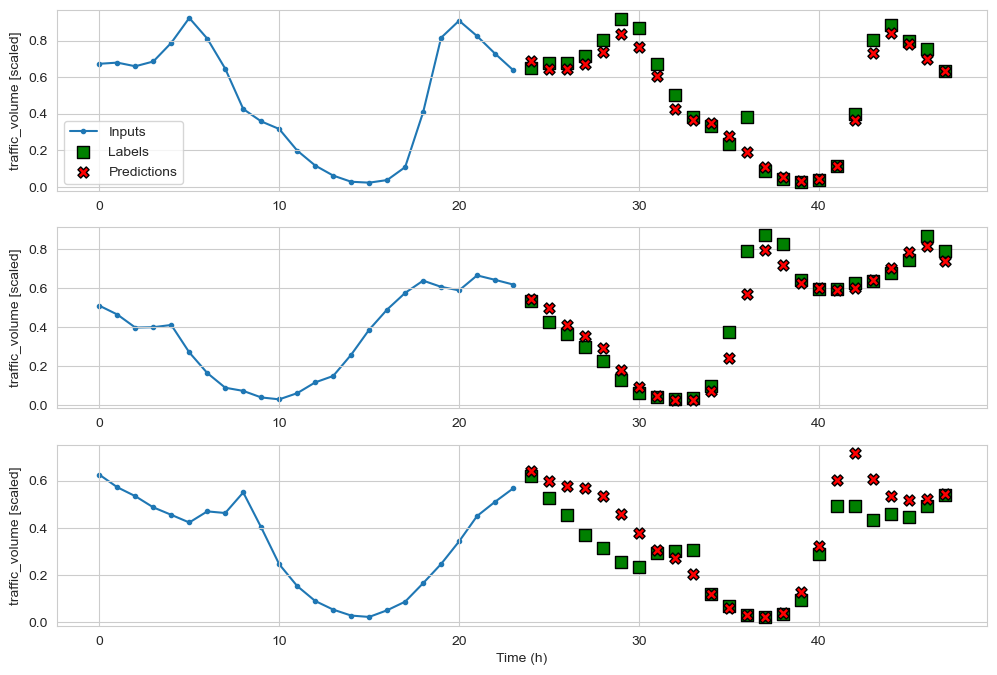

In [24]:
multi_window.plot(ms_lstm_model)

* Here we can see more discrepancies between the predictions and labels.
* Now taking the metrics of the previous models,

In [25]:
ms_mae_val = [0.353, 0.247, 0.089, 0.074]
ms_mae_test = [0.348, 0.238, 0.077, 0.06]

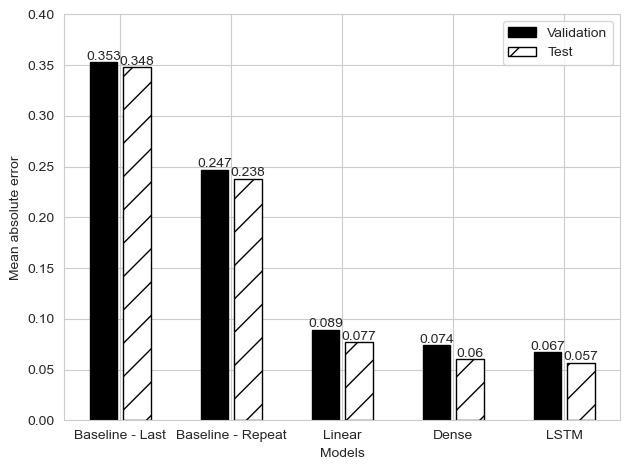

In [26]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()


* Here also LSTM is the best model achieved so far.

## LSTM as a multi-output model

* We will predict both the traffic volume and tempearature.

In [27]:
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [28]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

In [29]:
history = compile_and_fit(mo_lstm_model, mo_wide_window)

Epoch 1/50
384/384 [==============================] - 14s 23ms/step - loss: 0.0338 - mean_absolute_error: 0.1209 - val_loss: 0.0126 - val_mean_absolute_error: 0.0714
Epoch 2/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0076 - mean_absolute_error: 0.0559 - val_loss: 0.0050 - val_mean_absolute_error: 0.0439
Epoch 3/50
384/384 [==============================] - 8s 21ms/step - loss: 0.0039 - mean_absolute_error: 0.0397 - val_loss: 0.0030 - val_mean_absolute_error: 0.0356
Epoch 4/50
384/384 [==============================] - 8s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0346 - val_loss: 0.0023 - val_mean_absolute_error: 0.0315
Epoch 5/50
384/384 [==============================] - 9s 22ms/step - loss: 0.0025 - mean_absolute_error: 0.0315 - val_loss: 0.0020 - val_mean_absolute_error: 0.0288
Epoch 6/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0023 - mean_absolute_error: 0.0295 - val_loss: 0.0019 - val_mean_absolute_error: 0.0273
Epoch 7/5

In [30]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 1s 8ms/step - loss: 9.8620e-04 - mean_absolute_error: 0.0196


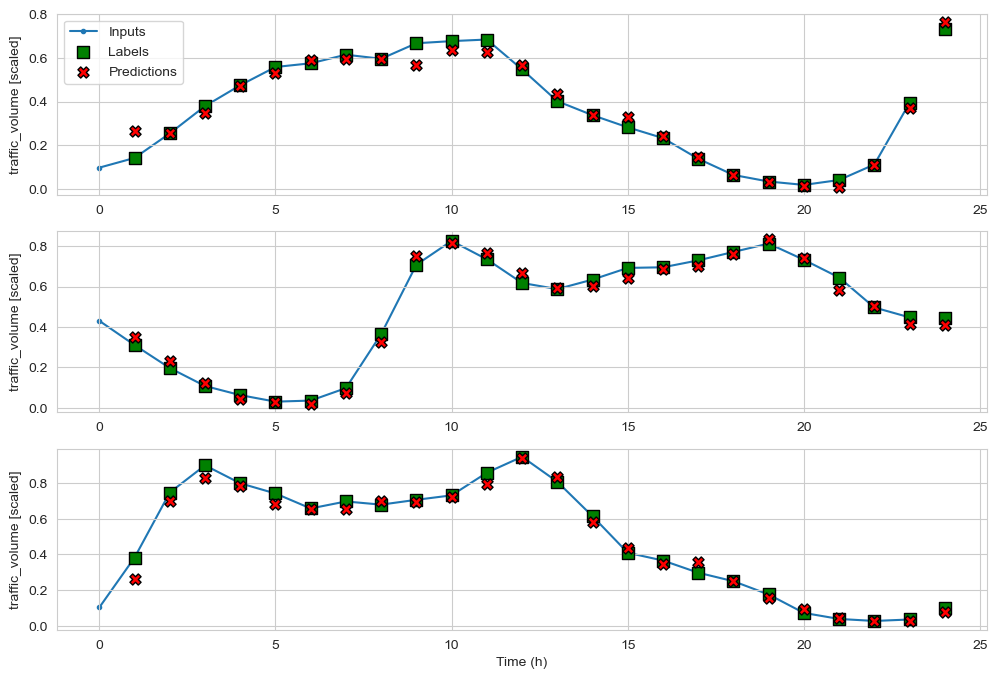

In [31]:
mo_wide_window.plot(mo_lstm_model)

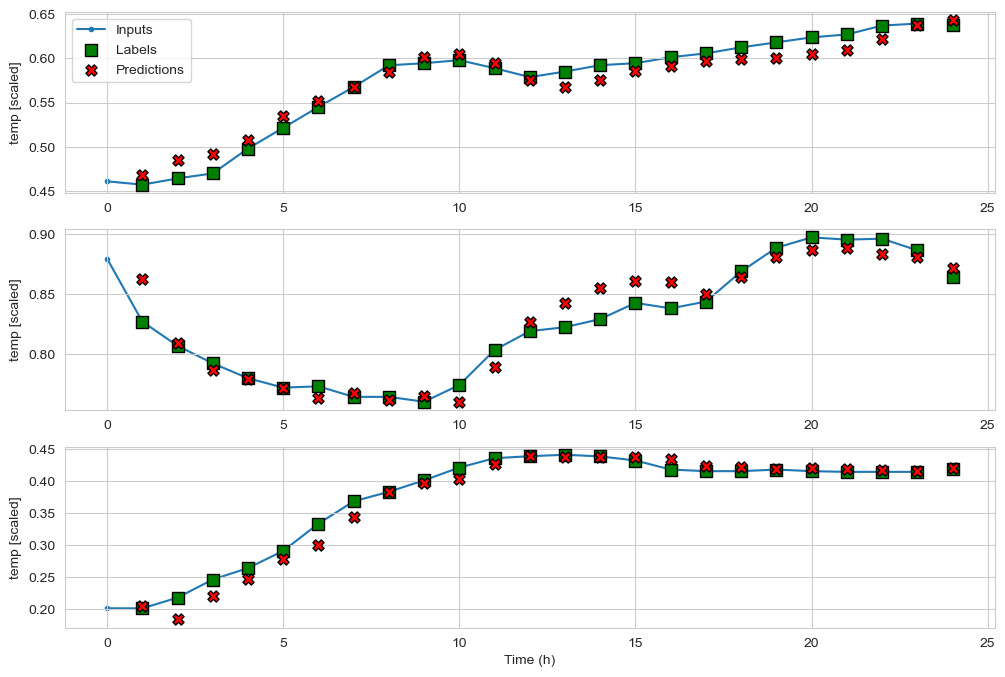

In [32]:
mo_wide_window.plot(mo_lstm_model, plot_col='temp')

* Now comparing with previous model metrics,

In [36]:
mo_mae_val = [0.048, 0.038, 0.021]
mo_mae_test = [0.047, 0.036, 0.019]

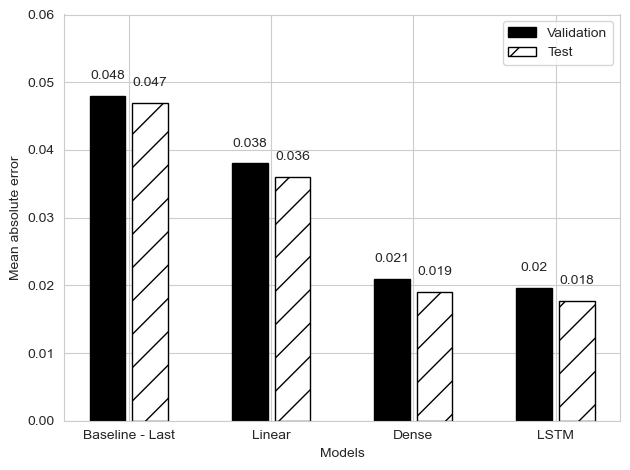

In [37]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* As we can see in all cases, the LSTM model performed the best.